# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [0]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import math
import os
import pickle
import re
import sys

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

style.use('ggplot')

BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

import pt_util

--2019-11-14 19:25:56--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.19MB/s    in 1.0s    

2019-11-14 19:25:57 (2.19 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        data = data.replace('\n', ' ').replace('\t', ' ')

    idx = 0
    voc2ind = {' ': 0}

    for i in range(26):
        # 'A'-'Z'
        idx += 1
        voc2ind[chr(i+65)] = idx
        # 'a'-'z'
        idx += 1
        voc2ind[chr(i+97)] = idx

    for i in range(10):
        # '0'-'9'
        idx += 1
        voc2ind[str(i)] = idx

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            idx += 1
            voc2ind[char] = idx
            
    ind2voc = {val: key for key, val in voc2ind.items()}

    print('voc2ind dict ({} characters): {} '.format(len(voc2ind), voc2ind))
    print('ind2voc dict ({} indexs): {}'.format(len(ind2voc), ind2voc))

    train_text = [ voc2ind.get(char, 0) for char in data[:5000000] ]
    test_text  = [ voc2ind.get(char, 0) for char in data[5000000:] ]

    print('train_text consists of {} characters ({:.4f}% for the corpus)'.format(len(train_text), len(train_text)/len(data)))
    print('test_text consists of {} characters ({:.4f}% for the corpus)'.format(len(test_text),len(test_text)/len(data)))

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# testing prepare_data() preprocessing  
# prepare_data(DATA_PATH + 'harry_potter.txt')

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        self.trimmed_data = []

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)
            self.text_data = dataset['tokens']

            self.text_data_size = len(self.text_data)
            self.batch_number = self.text_data_size//self.batch_size//self.sequence_length

            print('Total data number: ', self.text_data_size)
            print('Total batch number: ', self.batch_number)
            print('Total trimmed/omitted data number: {}/{}'.format(self.batch_size*self.batch_number*self.sequence_length, self.text_data_size-self.batch_size*self.batch_number*self.sequence_length))

            self.trimmed_data = [ [] for x in range(self.batch_number) ]

            for i in range(self.batch_number):
                for j in range(self.batch_size):
                    start_idx = i * self.sequence_length + j * self.text_data_size/self.batch_size
                    end_idx = start_idx + ( self.sequence_length + 1 )
                    self.trimmed_data[i].append(self.text_data[int(start_idx):int(end_idx)])


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.batch_number * self.batch_size
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        data = self.trimmed_data[idx//self.batch_size][idx%self.batch_size]
        return torch.LongTensor(data[:-1]), torch.LongTensor(data[1:])

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru_1 = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru_1(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [0]:
class HarryPotterGRUNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterGRUNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru_1 = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.gru_2 = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru_1(x, hidden_state)
        x, hidden_state = self.gru_2(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [0]:
class HarryPotterLSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterLSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.8
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, x, hidden, vocab, temperature):

    outputs = []   
    
    for ii in range(sequence_length):
        x = x.max(-1)[1]
        outputs.append(x)
        x, hidden = model.inference(x, hidden, temperature)
    
    return outputs

    
def sample_sampling_strategy(sequence_length, model, x, hidden, vocab, temperature):
    
    outputs = []
    
    for ii in range(sequence_length):
        x = torch.multinomial(x, 1)
        outputs.append(x)
        x, hidden = model.inference(x, hidden, temperature)

    return outputs


def beam_sampling_strategy(sequence_length, beam_width, model, x, hidden, vocab, device, temperature):
    
    outputs = []
    beam_list = [([], x, hidden, -0.01)]

    for ii in range(sequence_length):

         new_beam_list = []

        for (sequence, x, hidden, score) in beam_list:
            # Compute the next distribution over the output space for that state
            # Sample from the distribution with replacement
            sampled_x = torch.multinomial(x, 10)
            for char in sampled_x[0]:
                char_x = char
                
                cur_x, h = model.inference(char_x, hidden, temperature)
                new_sequence = sequence + [char_x]
                new_score = score - math.log(max(1e-20, x.data[0][char]))

                new_beam_list.append((new_sequence, cur_x, h, new_score))

        # Throw out all but the top N=beam_width beams
        beam = sorted(new_beam_list, key = lambda x: x[-1])[:beam_width]

    outputs = beam[0][0]

    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH, temperature=TEMPERATURE):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden, temperature)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab, temperature)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, BEAM_WIDTH, model, output, hidden, vocab, device, temperature)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# def eval_final_model(model, vocab, device):
#     seed_words = 'Harry Potter, you are a '
#     sequence_length = 150

#     generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
#     print('generated with max\t with TEMPERATURE={}\t {}'.format(TEMPERATURE, generated_sentence) )

#     for ii in range(10):
#         generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
#         print('generated with sample\t with TEMPERATURE={}\t {}'.format(TEMPERATURE, generated_sentence) )

#     for ii in range(10):
#         generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
#         print('generated with beam\t', generated_sentence)

# eval_final_model(final_model, vocab, device)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        # train loss
        train_loss = np.mean(losses)
        # train perplexity
        train_perplexity = np.exp(train_loss)
    return train_loss, train_perplexity


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    # test losss
    test_loss /= len(test_loader)
    # test accuracy
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)
    # test perplexity
    test_perplexity = np.exp(test_loss)

    print('\nTest set: Average loss: {:.3f}, Accuracy: {}/{} ({:.3f}%), Perplexity: {}\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length), test_perplexity))

    return test_loss, test_accuracy, test_perplexity

In [0]:
def plot(x_values, y_values, title, xlabel, ylabel):
    plt.figure(figsize=(10, 4))
    plt.plot(x_values, y_values, linewidth=0.9)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

def train_and_test_versus_epoch(x_values, y1_values, y2_values, label1, label2, title, xlabel, ylabel):
    plt.figure(figsize=(10, 4))
    plt.plot(x_values, y1_values, label=label1, linewidth=0.9)
    plt.plot(x_values, y2_values, label=label2, linewidth=0.9)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    legend = plt.legend(loc='upper right')
    legend.get_frame().set_facecolor('white')

    plt.show()

In [0]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 5e-3
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_baseline.pkl'

    # Harry Potter Cropus
    prepare_data(DATA_PATH + 'harry_potter.txt')
    # Game of Thrones Cropus
    # prepare_data(DATA_PATH + 'game_of_thrones.txt')

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)
    print('')

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)
    # model = HarryPotterGRUNet(data_train.vocab_size(), FEATURE_SIZE*2).to(device)
    # model = HarryPotterLSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0
    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    
    # test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
    # test_losses.append((start_epoch, test_loss))
    # test_accuracies.append((start_epoch, test_accuracy))
    # test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            print('Model Configuration')
            print(model)

            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))

            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            # train_loss, train_perplexity = train_lstm(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            # test_loss, test_accuracy, test_perplexity = test_lstm(model, device, test_loader)

            # record train/test losses, test accuracies, train/test perplexity
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))

            print('')
            print('********* Train Perplexity: {:.4f} / Test Perplexity: {:.4f} *********'.format(train_perplexity, test_perplexity))
            print('')

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))

            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/baseline/%03d.pt' % epoch)
            # seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            # generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            # for ii in range(3):
            #     generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'sample')
            #     print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language(model, device, seed_words, 100, vocab, 'beam')
            # print('generated beam\t\t', generated_sentence)
            # print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/baseline/%03d.pt' % epoch, 0)
        ep1, val1 = zip(*train_losses)
        ep2, val2 = zip(*test_losses)
        train_and_test_versus_epoch(ep1, val1, val2, 'Train Loss', 'Test Loss', 'Train/Test Loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep1, val1 = zip(*train_perplexities)
        ep2, val2 = zip(*test_perplexities)
        train_and_test_versus_epoch(ep1, val1, val2, 'Train Perplexity', 'Test Perplexity', 'Train/Test Perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

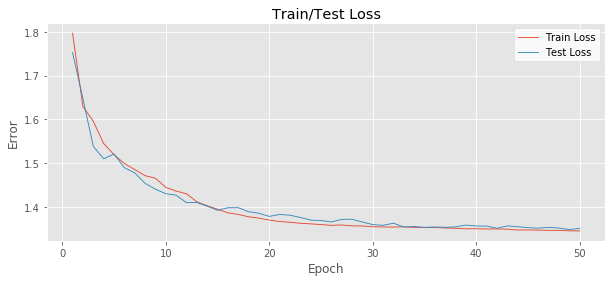

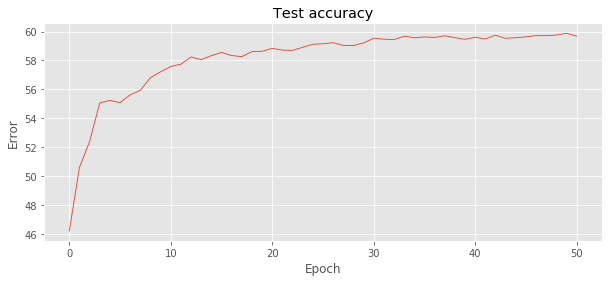

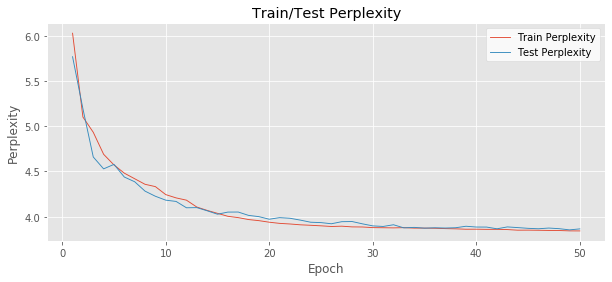

In [0]:
LOG_PATH = DATA_PATH + 'logs/log_baseline.pkl'

train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
ep1, val1 = zip(*train_losses)
ep2, val2 = zip(*test_losses)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Loss', 'Test Loss', 'Train/Test Loss', 'Epoch', 'Error')
ep, val = zip(*test_accuracies)
plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
ep1, val1 = zip(*train_perplexities)
ep2, val2 = zip(*test_perplexities)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Perplexity', 'Test Perplexity', 'Train/Test Perplexity', 'Epoch', 'Perplexity')

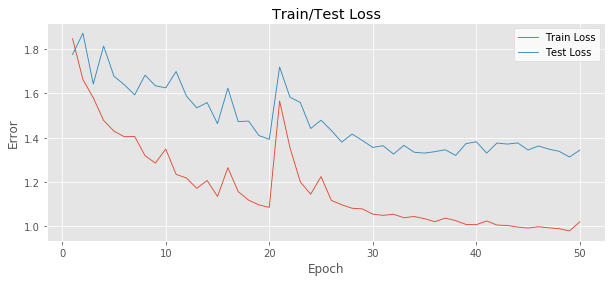

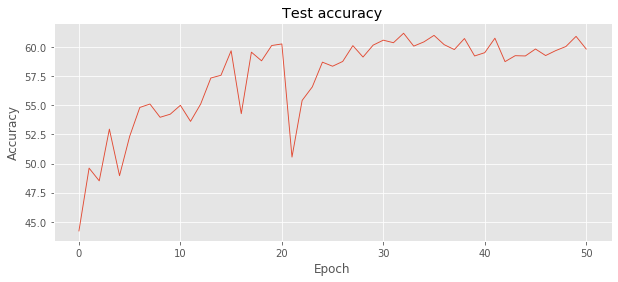

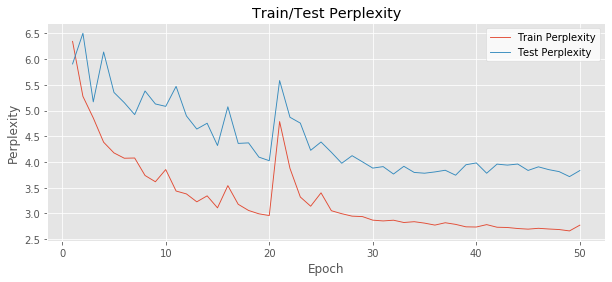

In [0]:
LOG_PATH = DATA_PATH + 'logs/log_gru.pkl'

train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
ep1, val1 = zip(*train_losses)
ep2, val2 = zip(*test_losses)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Loss', 'Test Loss', 'Train/Test Loss', 'Epoch', 'Error')
ep, val = zip(*test_accuracies)
plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
ep1, val1 = zip(*train_perplexities)
ep2, val2 = zip(*test_perplexities)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Perplexity', 'Test Perplexity', 'Train/Test Perplexity', 'Epoch', 'Perplexity')

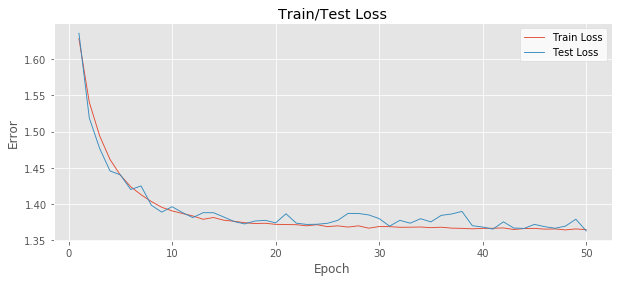

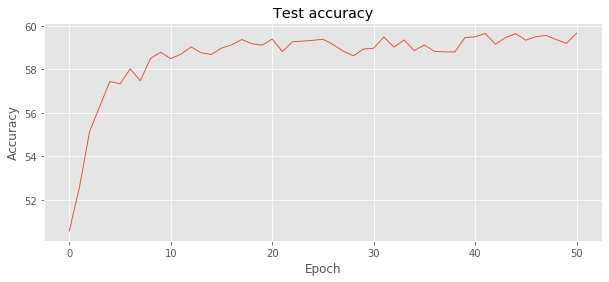

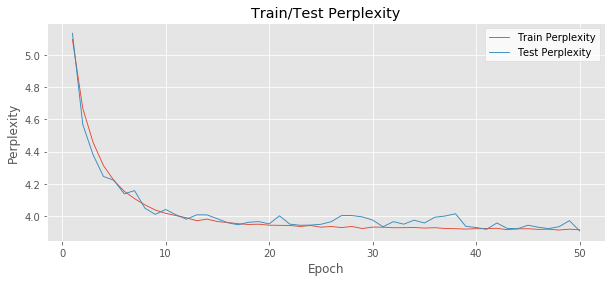

In [0]:
LOG_PATH = DATA_PATH + 'logs/log_lstm.pkl'

train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
ep1, val1 = zip(*train_losses)
ep2, val2 = zip(*test_losses)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Loss', 'Test Loss', 'Train/Test Loss', 'Epoch', 'Error')
ep, val = zip(*test_accuracies)
plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')
ep1, val1 = zip(*train_perplexities)
ep2, val2 = zip(*test_perplexities)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Perplexity', 'Test Perplexity', 'Train/Test Perplexity', 'Epoch', 'Perplexity')

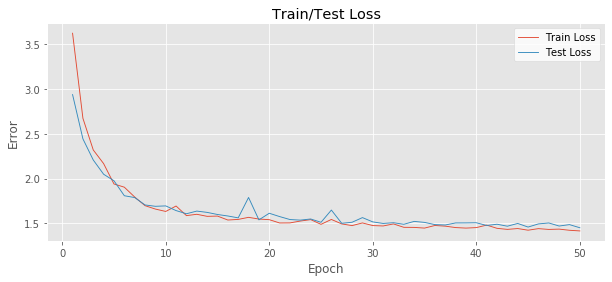

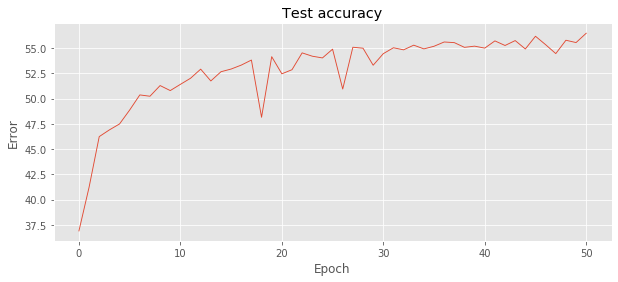

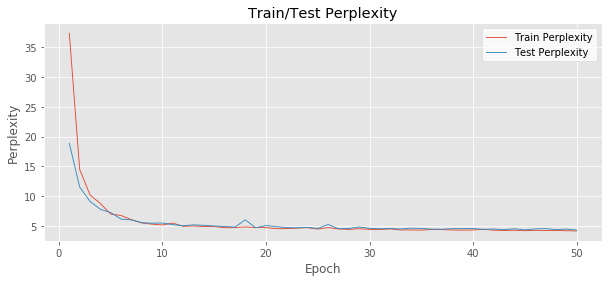

In [0]:
LOG_PATH = DATA_PATH + 'logs/log_got.pkl'

train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
ep1, val1 = zip(*train_losses)
ep2, val2 = zip(*test_losses)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Loss', 'Test Loss', 'Train/Test Loss', 'Epoch', 'Error')
ep, val = zip(*test_accuracies)
plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
ep1, val1 = zip(*train_perplexities)
ep2, val2 = zip(*test_perplexities)
train_and_test_versus_epoch(ep1[1:], val1[1:], val2[1:], 'Train Perplexity', 'Test Perplexity', 'Train/Test Perplexity', 'Epoch', 'Perplexity')

#Part 7: Experiments

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter, you are a '
    sequence_length = 150

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    